In [1]:
import torch
import torchvision as vision
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv("../input/creditcardfraud/creditcard.csv")

In [3]:
df.rename(columns={'Class':'label'},inplace=True)

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
df['logAmount']=np.log10(df.Amount+0.00001)

In [6]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,label,logAmount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,2.174990
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.429754
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,2.578249
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,2.091667
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.845036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,-0.113504
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.394277
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.831742
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1.000000


In [7]:
df.drop(['Time','Amount'],axis=1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,label,logAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,2.174990
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.429754
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,2.578249
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,2.091667
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,1.845036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.113504
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,1.394277
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,1.831742
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,1.000000


In [8]:

df=df[[col for col in df if col not in ['label','logAmount']]+['logAmount','label']]

In [9]:
df=df.drop(['Time','Amount'],axis=1)

In [10]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,logAmount,label
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,2.174990,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.429754,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,2.578249,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,2.091667,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,1.845036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.113504,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,1.394277,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,1.831742,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,1.000000,0


In [11]:
fraud=df[df.label==1]
clean=df[df.label==0]

In [12]:
print("# of fraud samples {}. # of clean samples {} ".format(
            len(fraud),len(clean)))

# of fraud samples 492. # of clean samples 284315 


In [13]:
TRAINING_SAMPLE=200000
VALIDATE_SIZE=0.2

In [14]:
clean

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,logAmount,label
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,2.174990,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.429754,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,2.578249,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,2.091667,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,1.845036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.113504,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,1.394277,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,1.831742,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,1.000000,0


In [15]:
clean=clean.sample(frac=1).reset_index(drop=True)
train_input=clean.iloc[:TRAINING_SAMPLE].drop('label',axis=1)
test_input=clean.iloc[TRAINING_SAMPLE:].append(fraud)

In [16]:
test_input.label.value_counts()

0    84315
1      492
Name: label, dtype: int64

In [17]:
test_input

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,logAmount,label
200000,1.197366,-0.756171,-0.011840,-0.826552,-0.577681,-0.156308,-0.411352,-0.028165,-1.207275,0.730809,...,0.326440,0.703667,-0.218937,-0.263552,0.554348,-0.093928,-0.007341,0.009364,1.988336,0
200001,1.158715,0.079412,0.569055,0.513574,-0.429864,-0.339856,-0.186034,0.127114,-0.072121,0.089726,...,-0.176755,-0.566753,0.191315,0.189937,0.051406,0.097709,-0.023078,0.005259,0.296667,0
200002,1.137881,-1.122131,1.270094,-0.661879,-1.829914,-0.174754,-1.330653,0.180918,-0.396554,0.719582,...,0.536963,1.260350,-0.168420,0.381740,0.242037,-0.068646,0.035238,0.037852,2.000000,0
200003,1.156939,0.037215,0.556799,0.519507,-0.479754,-0.352714,-0.222487,0.158242,0.011252,0.105584,...,-0.182662,-0.612268,0.197305,0.174883,0.032497,0.099480,-0.026816,0.004199,0.429754,0
200004,1.382374,-0.355241,-0.027694,-0.687986,-0.554764,-0.451265,-0.616841,-0.000407,-0.691489,0.190592,...,-0.157661,-0.558521,0.089689,-0.547425,0.207129,-0.417154,0.033803,0.034529,1.106191,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,2.591065,1
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,-0.119181,1
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,1.891482,1
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,2.389166,1


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline

RANDOM_SEED = 42
# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(train_input, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
#X_test, y_test = test_input.drop('label', axis=1).values, test_input.label.values
X_test, y_test = test_input.drop('label', axis=1), test_input.label
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)
X_test_transformed = pipeline.transform(X_test)


In [19]:
X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,logAmount
200000,1.197366,-0.756171,-0.011840,-0.826552,-0.577681,-0.156308,-0.411352,-0.028165,-1.207275,0.730809,...,0.258727,0.326440,0.703667,-0.218937,-0.263552,0.554348,-0.093928,-0.007341,0.009364,1.988336
200001,1.158715,0.079412,0.569055,0.513574,-0.429864,-0.339856,-0.186034,0.127114,-0.072121,0.089726,...,-0.187983,-0.176755,-0.566753,0.191315,0.189937,0.051406,0.097709,-0.023078,0.005259,0.296667
200002,1.137881,-1.122131,1.270094,-0.661879,-1.829914,-0.174754,-1.330653,0.180918,-0.396554,0.719582,...,0.271979,0.536963,1.260350,-0.168420,0.381740,0.242037,-0.068646,0.035238,0.037852,2.000000
200003,1.156939,0.037215,0.556799,0.519507,-0.479754,-0.352714,-0.222487,0.158242,0.011252,0.105584,...,-0.221852,-0.182662,-0.612268,0.197305,0.174883,0.032497,0.099480,-0.026816,0.004199,0.429754
200004,1.382374,-0.355241,-0.027694,-0.687986,-0.554764,-0.451265,-0.616841,-0.000407,-0.691489,0.190592,...,0.054166,-0.157661,-0.558521,0.089689,-0.547425,0.207129,-0.417154,0.033803,0.034529,1.106191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,2.591065
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,-0.119181
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,1.891482
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,2.389166


In [20]:
X_test.shape

(84807, 29)

In [21]:
from torch.utils.data import Dataset,DataLoader

In [22]:
class CustomDataset(Dataset):
    def __init__(self,data):
        #self.data=frame.to_numpy(dtype=np.float32)        
        self.data=data
    def __getitem__(self,idx):
            return torch.as_tensor(self.data[idx],dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)

In [23]:
train_dataset=CustomDataset(X_train_transformed)

In [24]:
train_loader=DataLoader(train_dataset,batch_size=256)

In [26]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(in_features=29,out_features=29)
        self.fc2=nn.Linear(in_features=29,out_features=16)
        self.fc3=nn.Linear(in_features=16,out_features=8)
        self.fc4=nn.Linear(in_features=8,out_features=4)
        self.fc5=nn.Linear(in_features=4,out_features=2)
        
        self.fc6=nn.Linear(in_features=2,out_features=4)
        self.fc7=nn.Linear(in_features=4,out_features=8)
        self.fc8=nn.Linear(in_features=8,out_features=16)
        self.fc9=nn.Linear(in_features=16,out_features=29)
        self.fc10=nn.Linear(in_features=29,out_features=29)
        self.relu=nn.ELU()
    def forward(self,x):
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        x=self.relu(x)
        x=self.fc4(x)
        x=self.relu(x)
        x=self.fc5(x)
        x=self.relu(x)
        x=self.fc6(x)
        x=self.relu(x)
        x=self.fc7(x)
        x=self.relu(x)
        x=self.fc8(x)
        x=self.relu(x)
        x=self.fc9(x)
        x=self.relu(x)
        return x
        

In [27]:
from torch.nn import MSELoss

In [75]:
from torch.optim import Adam,SGD
model=Net()
optimizer=Adam(model.parameters())
#optimizer=SGD(model.parameters(),lr=0.6)
loss_fn=MSELoss()
epochs=50
for epoch in range(epochs):
    for x in train_loader:
        optimizer.zero_grad()
        y=model(x)
        loss=loss_fn(x,y)
        loss.backward()
        optimizer.step()
    print("epoch:{} loss {}".format(epoch,loss.item()))

epoch:0 loss 0.015992002561688423
epoch:1 loss 0.01414015144109726
epoch:2 loss 0.013436623848974705
epoch:3 loss 0.012872484512627125
epoch:4 loss 0.01262958999723196
epoch:5 loss 0.012513156980276108
epoch:6 loss 0.012378080748021603
epoch:7 loss 0.012038357555866241
epoch:8 loss 0.01182783767580986
epoch:9 loss 0.011640157550573349
epoch:10 loss 0.01153971441090107
epoch:11 loss 0.011478744447231293
epoch:12 loss 0.011430314742028713
epoch:13 loss 0.011387639679014683
epoch:14 loss 0.01134671550244093
epoch:15 loss 0.011306735686957836
epoch:16 loss 0.011267242953181267
epoch:17 loss 0.011223389767110348
epoch:18 loss 0.011171630583703518
epoch:19 loss 0.011110484600067139
epoch:20 loss 0.011028382927179337
epoch:21 loss 0.010915268212556839
epoch:22 loss 0.010760189965367317
epoch:23 loss 0.010575666092336178
epoch:24 loss 0.010429246351122856
epoch:25 loss 0.010326729156076908
epoch:26 loss 0.010241800919175148
epoch:27 loss 0.010149371810257435
epoch:28 loss 0.010072042234241962


In [76]:
#X_test_transformed =pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = model(torch.as_tensor(X_test_transformed,dtype=torch.float32))

In [77]:
mse = np.mean(np.power(X_test_transformed - reconstructions.detach().numpy(), 2), axis=1)

In [78]:
mse

array([0.00447126, 0.00559692, 0.0074709 , ..., 0.0349747 , 0.02971879,
       0.00307264])

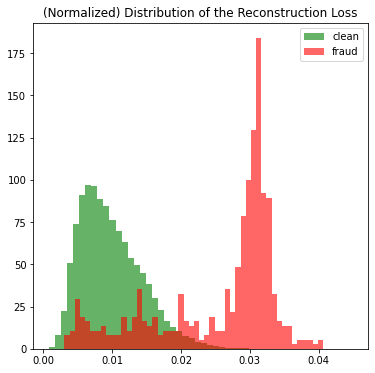

In [79]:
import matplotlib.pyplot as plt
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [80]:
THRESHOLD = 3

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD
#outliers=mse>0.02

In [81]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 1,246 outliers in a total of 84,807 transactions [1.47%].


In [82]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(outliers,y_test)

# true/false positives/negatives
(tn, fn, 
 fp, tp) = cm.flatten()

In [83]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were actual fraud(precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:
[[83415   146]
 [  900   346]]

% of transactions labeled as fraud that were actual fraud(precision): 346/(900+346) = 27.77%
% of fraudulent transactions were caught succesfully (recall):    346/(146+346) = 70.33%
